In [1]:
from __future__ import division

import pickle
import os
import sys
import copy
import random
import types
from queue import Queue

import numpy as np
import gym
from gym import spaces
from rllab.policies.categorical_gru_policy import CategoricalGRUPolicy
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.algos.trpo import TRPO
from rllab.misc.overrides import overrides

/home/sugandh/miniconda2/envs/rllab3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rc('savefig', dpi=300)
mpl.rc('text', usetex=True)

In [4]:
data_dir = os.path.join('.', 'data')

In [5]:
def sample_const_delay(d):
  return (lambda: d)

In [6]:
class StudentEnv(gym.Env):
  
  def __init__(self, n_items=10, n_steps=100, discount=1., sample_delay=None, reward_func='likelihood'):
    if sample_delay is None:
      self.sample_delay = sample_const_delay(1)
    else:
      self.sample_delay = sample_delay
    self.curr_step = None
    self.n_steps = n_steps
    self.n_items = n_items
    self.now = 0
    self.curr_item = 0
    self.curr_outcome = None
    self.curr_delay = None
    self.discount = discount
    self.reward_func = reward_func
    
    self.action_space = spaces.Discrete(n_items)
    self.observation_space = spaces.Box(np.zeros(4), np.array([n_items-1, 1, sys.maxsize, sys.maxsize]))
    
  def _recall_likelihoods(self):
    raise NotImplementedError
    
  def _recall_log_likelihoods(self, eps=1e-9):
    return np.log(eps + self._recall_likelihoods())
  
  def _update_model(self, item, outcome, timestamp, delay):
    raise NotImplementedError
  
  def _obs(self):
    timestamp = self.now - self.curr_delay
    return np.array([self.curr_item, self.curr_outcome, timestamp, self.curr_delay], dtype=int)
  
  def _rew(self):
    if self.reward_func == 'likelihood':
      return self._recall_likelihoods().mean()
    elif self.reward_func == 'log_likelihood':
      return self._recall_log_likelihoods().mean()
    else:
      raise ValueError
  
  def _step(self, action):
    if self.curr_step is None or self.curr_step >= self.n_steps:
      raise ValueError
      
    if action < 0 or action >= self.n_items:
      raise ValueError
      
    self.curr_item = action
    self.curr_outcome = 1 if np.random.random() < self._recall_likelihoods()[action] else 0
        
    self.curr_step += 1
    self.curr_delay = self.sample_delay()
    self.now += self.curr_delay
    
    self._update_model(self.curr_item, self.curr_outcome, self.now, self.curr_delay)
    
    obs = self._obs()
    r = self._rew()
    done = self.curr_step == self.n_steps
    info = {}
    
    return obs, r, done, info
    
  def _reset(self):
    self.curr_step = 0
    self.now = 0
    return self._step(np.random.choice(range(self.n_items)))[0]

In [7]:
item_difficulty_mean = 1
item_difficulty_std = 1

log_item_decay_exp_mean = 1
log_item_decay_exp_std = 1

log_delay_coef_mean = 0
log_delay_coef_std = 0.01

def sample_item_difficulties(n_items):
  return np.random.normal(item_difficulty_mean, item_difficulty_std, n_items)

def sample_student_ability():
  return 0

def sample_window_cw(n_windows):
  x = 1 / (np.arange(1, n_windows+1, 1))**2
  return x[::-1]
  
def sample_window_nw(n_windows):
  x = 1 / (np.arange(1, n_windows+1, 1))**2
  return x[::-1]

def sample_item_decay_exps(n_items):
  return np.exp(np.random.normal(log_item_decay_exp_mean, log_item_decay_exp_std, n_items))

def sample_student_decay_exp():
  return 0

def sample_delay_coef():
  return np.exp(np.random.normal(log_delay_coef_mean, log_delay_coef_std))

In [8]:
class DASHEnv(StudentEnv):
  
  def __init__(
    self, n_windows=5, item_difficulties=None, student_ability=None,
    window_cw=None, window_nw=None, item_decay_exps=None, student_decay_exp=None, 
    delay_coef=None, **kwargs):
    super(DASHEnv, self).__init__(**kwargs)
    
    if item_difficulties is None:
      self.item_difficulties = sample_item_difficulties(self.n_items)
    else:
      if len(item_difficulties) != self.n_items:
        raise ValueError
      self.item_difficulties = item_difficulties
      
    if student_ability is None:
      self.student_ability = sample_student_ability()
    else:
      self.student_ability = student_ability
      
    if item_decay_exps is None:
      self.item_decay_exps = sample_item_decay_exps(self.n_items)
    else:
      if len(item_decay_exps) != self.n_items:
        raise ValueError
      self.item_decay_exps = item_decay_exps
    
    if student_decay_exp is None:
      self.student_decay_exp = sample_student_decay_exp()
    else:
      self.student_decay_exp = student_decay_exp
      
    if delay_coef is None:
      self.delay_coef = sample_delay_coef()
    else:
      self.delay_coef = delay_coef
            
    if self.n_steps % n_windows != 0:
      raise ValueError
    self.n_windows = n_windows
    self.window_size = self.n_steps // self.n_windows
    self.n_correct = None
    self.n_attempts = None
    
    if window_cw is None:
      window_cw = sample_window_cw(self.n_windows)
    if window_nw is None:
      window_nw = sample_window_nw(self.n_windows)
    if len(window_cw) != n_windows or len(window_nw) != n_windows:
      raise ValueError
    
    self.window_cw = np.tile(window_cw, self.n_items).reshape((self.n_items, self.n_windows))
    self.window_nw = np.tile(window_nw, self.n_items).reshape((self.n_items, self.n_windows))
    
    self.init_tlasts = np.exp(np.random.normal(0, 0.01, self.n_items))
    self._init_params()
    
  def _init_params(self):
    self.n_correct = np.zeros((self.n_items, self.n_windows))
    self.n_attempts = np.zeros((self.n_items, self.n_windows))
    #self.tlasts = np.ones(self.n_items) * -sys.maxsize
    self.tlasts = copy.deepcopy(self.init_tlasts)
    
  def _current_window(self):
    return min(self.n_windows - 1, self.curr_step // self.window_size)
    
  def _recall_likelihoods(self):
    curr_window = self._current_window()
    study_histories = (self.window_cw[:, :curr_window]*np.log(
      1 + self.n_correct[:, :curr_window]) + self.window_nw[:, :curr_window]*np.log(
      1 + self.n_attempts[:, :curr_window])).sum(axis=1)
    m = 1 / (1 + np.exp(-(self.student_ability - self.item_difficulties + study_histories)))
    f = np.exp(self.student_decay_exp - self.item_decay_exps)
    delays = self.now - self.tlasts
    return m / (1 + self.delay_coef * delays)**f
  
  def _update_model(self, item, outcome, timestamp, delay):
    curr_window = self._current_window()
    if outcome == 1:
      self.n_correct[item, curr_window] += 1
    self.n_attempts[item, curr_window] += 1
    self.tlasts[item] = timestamp
    
  def _reset(self):
    self._init_params()
    return super(DASHEnv, self)._reset()

In [9]:
def sample_item_decay_rates(n_items):
  return np.exp(np.random.normal(np.log(0.077), 1, n_items))

In [10]:
class EFCEnv(StudentEnv):
  '''exponential forgetting curve'''
  
  def __init__(self, item_decay_rates=None, **kwargs):
    super(EFCEnv, self).__init__(**kwargs)
    
    if item_decay_rates is None:
      self.item_decay_rates = sample_item_decay_rates(self.n_items)
    else:
      self.item_decay_rates = item_decay_rates
    
    self.tlasts = None
    self.strengths = None
    self.init_tlasts = np.exp(np.random.normal(0, 1, self.n_items))
    self._init_params()
    
  def _init_params(self):
    #self.tlasts = np.ones(self.n_items) * -sys.maxsize
    self.tlasts = copy.deepcopy(self.init_tlasts)
    self.strengths = np.ones(self.n_items)
    
  def _recall_likelihoods(self):
    return np.exp(-self.item_decay_rates*(self.now - self.tlasts)/self.strengths)
  
  def _update_model(self, item, outcome, timestamp, delay):
    #self.strengths[item] = max(1, self.strengths[item] + 2 * outcome - 1) # fictional Leitner system
    self.strengths[item] += 1 # num attempts
    self.tlasts[item] = timestamp
    
  def _reset(self):
    self._init_params()
    return super(EFCEnv, self)._reset()

In [11]:
def sample_loglinear_coeffs(n_items):
  coeffs = np.array([1, 1, 0])
  coeffs = np.concatenate((coeffs, np.random.normal(0, 1, n_items)))
  return coeffs

In [12]:
class HLREnv(StudentEnv):
  '''exponential forgetting curve with log-linear memory strength'''
  
  def __init__(self, loglinear_coeffs=None, **kwargs):
    super(HLREnv, self).__init__(**kwargs)
    
    if loglinear_coeffs is None:
      self.loglinear_coeffs = sample_loglinear_coeffs(self.n_items)
    else:
      self.loglinear_coeffs = loglinear_coeffs
    assert self.loglinear_coeffs.size == 3 + self.n_items
          
    self.tlasts = None
    self.loglinear_feats = None
    self.init_tlasts = np.exp(np.random.normal(0, 1, self.n_items))
    self._init_params()
    
  def _init_params(self):
    #self.tlasts = np.ones(self.n_items) * -sys.maxsize
    self.tlasts = copy.deepcopy(self.init_tlasts)
    self.loglinear_feats = np.zeros((self.n_items, 3)) # n_attempts, n_correct, n_incorrect
    self.loglinear_feats = np.concatenate((self.loglinear_feats, np.eye(self.n_items)), axis=1)
    
  def _strengths(self):
    return np.exp(np.einsum('j,ij->i', self.loglinear_coeffs, self.loglinear_feats))
    
  def _recall_likelihoods(self):
    return np.exp(-(self.now - self.tlasts)/self._strengths())
  
  def _update_model(self, item, outcome, timestamp, delay):
    self.loglinear_feats[item, 0] += 1
    self.loglinear_feats[item, 1 if outcome == 1 else 2] += 1
    self.tlasts[item] = timestamp
    
  def _reset(self):
    self._init_params()
    return super(HLREnv, self)._reset()

In [13]:
normalize = lambda x: x / x.sum()

In [14]:
class Tutor(object):
  
  def __init__(self):
    pass
  
  def _next_item(self):
    raise NotImplementedError
  
  def _update(self, item, outcome, timestamp, delay):
    raise NotImplementedError
  
  def act(self, obs):
    self._update(*list(obs))
    return self._next_item()
  
  def learn(self, r):
    pass
  
  def train(self, env, n_eps=10):
    return run_eps(self, env, n_eps=n_eps)
  
  def reset(self):
    raise NotImplementedError

In [15]:
class RandTutor(Tutor):
  '''sample item uniformly at random'''
  
  def __init__(self, n_items, init_timestamp=0):
    self.n_items = n_items
    
  def _next_item(self):
    return np.random.choice(range(self.n_items))
  
  def _update(self, item, outcome, timestamp, delay):
    pass
  
  def reset(self):
    pass

In [49]:
class LeitnerTutor(Tutor):
  '''sample item from an infinite leitner queue network'''
  
  
  def __init__(self, n_items, init_timestamp=0, arrival_prob=0.1):
    self.arrival_prob = arrival_prob
    self.n_items = n_items
    self.queues = None
    self.curr_q = None
    self.curr_item = None
    self.just_reset = False
    self.reset()
        
  def _next_item(self):    
    if self.curr_item is not None:
      raise ValueError
      
    n_queues = len(self.queues)
    q_sampling_rates = 1 / np.sqrt(np.arange(1, n_queues, 1))
    q_sampling_rates = np.array([x if not self.queues[i+1].empty() else 0 for i, x in enumerate(q_sampling_rates)])
    arrival_prob = self.arrival_prob if not self.queues[0].empty() else 0
    q_sampling_rates = np.concatenate((np.array([arrival_prob]), normalize(q_sampling_rates) * (1 - arrival_prob)))
    p = normalize(q_sampling_rates)
    
    if self.queues[0].qsize() == self.n_items: # no items have been shown yet
      self.curr_q = 0
    else:
      self.curr_q = np.random.choice(range(n_queues), p=p)
    self.curr_item = self.queues[self.curr_q].get(False)
    return self.curr_item
    
  def _update(self, item, outcome, timestamp, delay):
    if not self.just_reset and (self.curr_item is None or item != self.curr_item):
      raise ValueError
      
    if self.just_reset:
      for i in range(self.n_items):
        if i != item:
          self.queues[0].put(i)
      
    next_q = max(1, self.curr_q + 2 * int(outcome) - 1)
    if next_q == len(self.queues):
      self.queues.append(Queue())
    self.queues[next_q].put(item)
    
    self.curr_item = None
    self.curr_q = None
    self.just_reset = False
    
  def reset(self):
    self.queues = [Queue()]
      
    self.curr_item = None
    self.curr_q = 0
    self.just_reset = True
    
  def train(self, gym_env, n_eps=10):
    arrival_probs = np.arange(0, 1, 0.01)
    n_eps_per_aprob = n_eps // arrival_probs.size
    assert n_eps_per_aprob > 0
    best_reward = None
    best_aprob = None
    for aprob in arrival_probs:
      self.arrival_prob = aprob
      reward = np.mean(run_eps(self, env, n_eps=n_eps_per_aprob))
      print(type(env))
      if best_reward is None or reward > best_reward:
        best_aprob = aprob
        best_reward = reward
    self.arrival_prob = best_aprob
    return run_eps(self, env, n_eps=n_eps)

In [50]:
class ThresholdTutor(Tutor):
  '''review item with recall likelihood closest to some threshold'''
  
  def __init__(self, n_items, env, init_timestamp=0):
    self.n_items = n_items
    self.threshold = None
    self.env = copy.deepcopy(env)
    self.env._reset()
  
  def _next_item(self):
    return np.argmin(np.abs(self.env._recall_likelihoods() - self.threshold))
  
  def _update(self, item, outcome, timestamp, delay):
    self.env._update_model(item, outcome, timestamp, delay)
    self.env.curr_step += 1
    self.env.now += delay
    
  def reset(self):
    self.env._reset()
  
  def train(self, env, n_eps=10):
    thresholds = np.arange(0, 1, 0.01)
    n_eps_per_thresh = n_eps // thresholds.size
    assert n_eps_per_thresh > 0
    best_reward = None
    best_thresh = None
    for thresh in thresholds:
      self.threshold = thresh
      reward = np.mean(run_eps(self, env, n_eps=n_eps_per_thresh))
      if best_reward is None or reward > best_reward:
        best_thresh = thresh
        best_reward = reward
    self.threshold = best_thresh
    return run_eps(self, env, n_eps=n_eps)

In [51]:
def make_rl_student_env(env):
  env = copy.deepcopy(env)

  env.n_item_feats = int(np.log(2 * env.n_items))
  env.item_feats = np.random.normal(
    np.zeros(2*env.n_items*env.n_item_feats), 
    np.ones(2*env.n_items*env.n_item_feats)).reshape((2*env.n_items, env.n_item_feats))
  env.observation_space = spaces.Box(
    np.concatenate((np.ones(env.n_item_feats) * -sys.maxsize, np.zeros(3))),
    np.concatenate((np.ones(env.n_item_feats + 2) * sys.maxsize, np.ones(1)))
  )

  def encode_item(self, item, outcome):
    return self.item_feats[self.n_items*outcome+item, :]

  def encode_delay(self, delay, outcome):
    v = np.zeros(2)
    v[outcome] = np.log(1+delay)
    return v

  def vectorize_obs(self, item, outcome, delay):
    return np.concatenate((self.encode_item(item, outcome), self.encode_delay(delay, outcome), np.array([outcome])))

  env._obs_orig = env._obs
  def _obs(self):
    item, outcome, timestamp, delay = env._obs_orig()
    return self.vectorize_obs(item, outcome, delay)
  
  env.encode_item = types.MethodType(encode_item, env)
  env.encode_delay = types.MethodType(encode_delay, env)
  env.vectorize_obs = types.MethodType(vectorize_obs, env)
  env._obs = types.MethodType(_obs, env)

  return env

In [52]:
from rllab.envs.gym_env import *

class MyGymEnv(GymEnv):
    def __init__(self, env, record_video=False, video_schedule=None, log_dir=None, record_log=False,
                 force_reset=False):
        if log_dir is None:
            if logger.get_snapshot_dir() is None:
                logger.log("Warning: skipping Gym environment monitoring since snapshot_dir not configured.")
            else:
                log_dir = os.path.join(logger.get_snapshot_dir(), "gym_log")
        Serializable.quick_init(self, locals())

        self.env = env
        self.env_id = ''

        assert not (not record_log and record_video)

        if log_dir is None or record_log is False:
            self.monitoring = False
        else:
            if not record_video:
                video_schedule = NoVideoSchedule()
            else:
                if video_schedule is None:
                    video_schedule = CappedCubicVideoSchedule()
            self.env = gym.wrappers.Monitor(self.env, log_dir, video_callable=video_schedule, force=True)
            self.monitoring = True

        self._observation_space = convert_gym_space(env.observation_space)
        logger.log("observation space: {}".format(self._observation_space))
        self._action_space = convert_gym_space(env.action_space)
        logger.log("action space: {}".format(self._action_space))
        self._horizon = self.env.n_steps
        self._log_dir = log_dir
        self._force_reset = force_reset

In [53]:
class DummyTutor(Tutor):
  
  def __init__(self, policy):
    self.policy = policy
    
  def act(self, obs):
    return self.policy(obs)
  
  def reset(self):
    pass

In [54]:
class LoggedTRPO(TRPO):  

  def __init__(self, *args, **kwargs):
    super(LoggedTRPO, self).__init__(*args, **kwargs)
    self.rew_chkpts = []

  @overrides
  def train(self):
    self.start_worker()
    self.init_opt()
    for itr in range(self.current_itr, self.n_itr):
      paths = self.sampler.obtain_samples(itr)
      samples_data = self.sampler.process_samples(itr, paths)
      self.optimize_policy(itr, samples_data)
      my_policy = lambda obs: self.policy.get_action(obs)[0]
      r, _ = run_ep(DummyTutor(my_policy), self.env)
      self.rew_chkpts.append(r)
      print(self.rew_chkpts[-1])
    self.shutdown_worker()

In [55]:
class RLTutor(Tutor):
  
  def __init__(self, n_items, init_timestamp=0):
    self.raw_policy = None
    self.curr_obs = None
  
  def train(self, gym_env, n_eps=10):
    env = MyGymEnv(gym_env)
    policy = CategoricalGRUPolicy(
      env_spec=env.spec, hidden_dim=32,
      state_include_action=False)
    self.raw_policy = LoggedTRPO(
        env=env,
        policy=policy,
        baseline=LinearFeatureBaseline(env_spec=env.spec),
        batch_size=4000,
        max_path_length=env.env.n_steps,
        n_itr=n_eps,
        discount=0.99,
        step_size=0.01,
        verbose=False
    )
    self.raw_policy.train()
    return self.raw_policy.rew_chkpts
    
  def reset(self):
    self.curr_obs = None
    self.raw_policy.reset()
  
  def _next_item(self):
    if self.curr_obs is None:
      raise ValueError
    return self.raw_policy.get_action(self.curr_obs)[0]
  
  def _update(self, obs):
    self.curr_obs = self.vectorize_obs(obs)
    
  def act(self, obs):
    self._update(obs)
    return self._next_item()
  
  def reset(self):
    self.raw_policy.reset()

In [56]:
#
# based on SM2_mnemosyne.py <Peter.Bienstman@UGent.be>
#

HOUR = 60 * 60 # Seconds in an hour.
DAY = 24 * HOUR # Seconds in a day.

class Card(object):
  
    def __init__(self, _id):
        self.grade = 0
        self.next_rep = 0
        self.last_rep = 0
        self.easiness = 0
        self.acq_reps = 0
        self.acq_reps_since_lapse = 0
        self.ret_reps = 0
        self.ret_reps_since_lapse = 0
        self.lapses = 0
        self._id = _id

class SuperMnemoTutor(Tutor):

    """Scheduler based on http://www.supermemo.com/english/ol/sm2.htm.
    Note that all intervals are in seconds, since time is stored as
    integer POSIX timestamps.

    Since the scheduling granularity is days, all cards due on the same time
    should become due at the same time. In order to keep the SQL query
    efficient, we do this by setting 'next_rep' the same for all cards that
    are due on the same day.

    In order to allow for the fact that the timezone and 'day_starts_at' can
    change after scheduling a card, we store 'next_rep' as midnight UTC, and
    bring local time and 'day_starts_at' only into play when querying the
    database.

    """
    
    def __init__(self, n_items, init_timestamp=0, non_memorised_cards_in_hand=10, fail_grade=0, pass_grade=2):
        self.non_memorised_cards_in_hand = non_memorised_cards_in_hand
        self.fail_grade = fail_grade
        self.pass_grade = pass_grade
        self.state = 1
        self.curr_step = 0
        self.card_of_id = [Card(i) for i in range(n_items)]
        self.curr_item = None
        self.now = init_timestamp
        self.unseen = set(range(n_items))
        self._card_ids_memorised = []
        self.reset()
        self.n_items = n_items

    def true_scheduled_interval(self, card):

        """Since 'next_rep' is always midnight UTC for retention reps, we need
        to take timezone and 'day_starts_at' into account to calculate the
        true scheduled interval when we are doing the actual repetition.
        This basically undoes the operations from 'adjusted_now'.
        Note that during the transition between different timezones, this is
        not well-defined, but the influence on the scheduler will be minor
        anyhow.

        """

        interval = card.next_rep - card.last_rep
        if card.grade < 2:
            return interval
        interval += HOUR
        return int(interval)

    def reset(self, new_only=False):

        """'_card_ids_in_queue' contains the _ids of the cards making up the
        queue.

        The corresponding fact._ids are also stored in '_fact_ids_in_queue',
        which is needed to make sure that no sister cards can be together in
        the queue at any time.

        '_fact_ids_memorised' has a different function and persists over the
        different stages invocations of 'rebuild_queue'. It can be used to
        control whether or not memorising a card will prevent a sister card
        from being pulled out of the 'unseen' pile, even after the queue has
        been rebuilt.

        '_card_id_last' is stored to avoid showing the same card twice in a
        row.

        'stage' stores the stage of the queue building, and is used to skip
        over unnecessary queries.

        """

        self._card_ids_in_queue = []
        self._card_id_last = None
        self.new_only = new_only
        if self.new_only == False:
            self.stage = 1
        else:
            self.stage = 3

    def set_initial_grade(self, cards, grade):

        """Sets the initial grades for a set of sister cards, making sure
        their next repetitions do no fall on the same day.

        Note that even if the initial grading happens when adding a card, it
        is seen as a repetition.

        """

        new_interval = self.calculate_initial_interval(grade)
        new_interval += self.calculate_interval_noise(new_interval)
        last_rep = self.now
        next_rep = last_rep + new_interval
        for card in cards:
            card.grade = grade
            card.easiness = 2.5
            card.acq_reps = 1
            card.acq_reps_since_lapse = 1
            card.last_rep = last_rep
            card.next_rep = next_rep
            next_rep += DAY

    def calculate_initial_interval(self, grade):

        """The first repetition is treated specially, and gives longer
        intervals, to allow for the fact that the user may have seen this
        card before.

        """

        return (0, 0, 1*DAY, 3*DAY, 4*DAY, 7*DAY) [grade]

    def calculate_interval_noise(self, interval):
        if interval == 0:
            noise = 0
        elif interval <= 10 * DAY:
            noise = random.choice([0, DAY])
        elif interval <= 60 * DAY:
            noise = random.uniform(-3 * DAY, 3 * DAY)
        else:
            noise = random.uniform(-0.05 * interval, 0.05 * interval)
        return int(noise)
      
    def cards_due_for_ret_rep(self):
        return sorted(
          range(self.n_items),
          key=lambda i: self.card_of_id[i].next_rep - self.card_of_id[i].last_rep,
          reverse=True)
        
    def cards_to_relearn(self, grade=0):
        # TODO: only return cards incorrectly answered in stage 1
        return [i for i in range(self.n_items) if self.card_of_id[i].grade == grade and i not in self.unseen]
        
    def cards_new_memorising(self, grade=0):
        return [i for i in range(self.n_items) if self.card_of_id[i].grade == grade and i not in self.unseen]
        
    def cards_unseen(self, limit=50):
        return random.sample(self.unseen, limit) if limit < len(self.unseen) else self.unseen
        
    def card(self, card_id):
        return self.card_of_id[card_id]
      
    def interval_multiplication_factor(self, *args):
        return 1

    def rebuild_queue(self, learn_ahead=False):
        self._card_ids_in_queue = []

        # Stage 1
        #
        # Do the cards that are scheduled for today (or are overdue), but
        # first do those that have the shortest interval, as being a day
        # late on an interval of 2 could be much worse than being a day late
        # on an interval of 50.
        # Fetch maximum 50 cards at the same time, as a trade-off between
        # memory usage and redoing the query.
        if self.stage == 1:
            for _card_id in self.cards_due_for_ret_rep():
                self._card_ids_in_queue.append(_card_id)
            if len(self._card_ids_in_queue):
                return
            self.stage = 2

        # Stage 2
        #
        # Now rememorise the cards that we got wrong during the last stage.
        # Concentrate on only a limited number of non memorised cards, in
        # order to avoid too long intervals between repetitions.
        limit = self.non_memorised_cards_in_hand
        non_memorised_in_queue = 0
        if self.stage == 2:
            for _card_id in self.cards_to_relearn(grade=1):
                if _card_id not in self._card_ids_in_queue:
                    if non_memorised_in_queue < limit:
                        self._card_ids_in_queue.append(_card_id)
                        non_memorised_in_queue += 1
                    if non_memorised_in_queue >= limit:
                        break
            for _card_id in self.cards_to_relearn(grade=0):
                if _card_id not in self._card_ids_in_queue:
                    if non_memorised_in_queue < limit:
                        self._card_ids_in_queue.append(_card_id)
                        self._card_ids_in_queue.append(_card_id)
                        non_memorised_in_queue += 1
                    if non_memorised_in_queue >= limit:
                        break
            random.shuffle(self._card_ids_in_queue)
            # Only stop when we reach the non memorised limit. Otherwise, keep
            # going to add some extra cards to get more spread.
            if non_memorised_in_queue >= limit:
                return
            # If the queue is empty, we can skip stage 2 in the future.
            if len(self._card_ids_in_queue) == 0:
                self.stage = 3

        # Stage 3
        #
        # Now do the cards which have never been committed to long-term
        # memory, but which we have seen before.
        # Use <= in the stage check, such that earlier stages can use
        # cards from this stage to increase the hand.
        if self.stage <= 3:
            for _card_id in self.cards_new_memorising(grade=1):
                if _card_id not in self._card_ids_in_queue:
                    if non_memorised_in_queue < limit:
                        self._card_ids_in_queue.append(_card_id)
                        non_memorised_in_queue += 1
                    if non_memorised_in_queue >= limit:
                        break
            for _card_id in self.cards_new_memorising(grade=0):
                if _card_id not in self._card_ids_in_queue:
                    if non_memorised_in_queue < limit:
                        self._card_ids_in_queue.append(_card_id)
                        self._card_ids_in_queue.append(_card_id)
                        non_memorised_in_queue += 1
                    if non_memorised_in_queue >= limit:
                        break
            random.shuffle(self._card_ids_in_queue)
            # Only stop when we reach the grade 0 limit. Otherwise, keep
            # going to add some extra cards to get more spread.
            if non_memorised_in_queue >= limit:
                return
            # If the queue is empty, we can skip stage 3 in the future.
            if len(self._card_ids_in_queue) == 0:
                self.stage = 4

        # Stage 4
        #
        # Now add some cards we have yet to see for the first time.
        # Use <= in the stage check, such that earlier stages can use
        # cards from this stage to increase the hand.
        if self.stage <= 4:
            # Preferentially keep away from sister cards for as long as
            # possible.
            for _card_id in self.cards_unseen(limit=min(limit, 50)):
                if _card_id not in self._card_ids_in_queue \
                    and _card_id not in self._card_ids_memorised:
                    self._card_ids_in_queue.append(_card_id)
                    non_memorised_in_queue += 1
                    if non_memorised_in_queue >= limit:
                        if self.new_only == False:
                            self.stage = 2
                        else:
                            self.stage = 3
                        return
            # If the queue is close to empty, start pulling in sister cards.
            if len(self._card_ids_in_queue) <= 2:
                for _card_id in self.cards_unseen(limit=min(limit, 50)):
                    if _card_id not in self._card_ids_in_queue:
                        self._card_ids_in_queue.append(_card_id)
                        non_memorised_in_queue += 1
                        if non_memorised_in_queue >= limit:
                            if self.new_only == False:
                                self.stage = 2
                            else:
                                self.stage = 3
                            return
            # If the queue is still empty, go to learn ahead of schedule.
            if len(self._card_ids_in_queue) == 0:
                self.stage = 5

        # Stage 5
        #
        # If we get to here, there are no more scheduled cards or new cards
        # to learn. The user can signal that he wants to learn ahead by
        # calling rebuild_queue with 'learn_ahead' set to True.
        # Don't shuffle this queue, as it's more useful to review the
        # earliest scheduled cards first. We only put 50 cards at the same
        # time into the queue, in order to save memory.
        if self.new_only == False:
            self.stage = 2
        else:
            self.stage = 3            
   
    def next_card(self, learn_ahead=False):
        # Populate queue if it is empty, and pop first card from the queue.
        if len(self._card_ids_in_queue) == 0:
            self.rebuild_queue(learn_ahead)
            if len(self._card_ids_in_queue) == 0:
                return None
        _card_id = self._card_ids_in_queue.pop(0)
        # Make sure we don't show the same card twice in succession.
        if self._card_id_last:
            while _card_id == self._card_id_last:
                # Make sure we have enough cards to vary, but exit in hopeless
                # situations.
                if len(self._card_ids_in_queue) == 0:
                    self.rebuild_queue(learn_ahead)
                    if len(self._card_ids_in_queue) == 0:
                        return None
                    if set(self._card_ids_in_queue) == set([_card_id]):
                        print("db db db db")
                        print(type(db))
                        return db.card(_card_id, is_id_internal=True)
                _card_id = self._card_ids_in_queue.pop(0)
        self._card_id_last = _card_id
        return self.card(_card_id)

    def _next_item(self):
        if self.curr_item is not None:
            raise ValueError
          
        card = self.next_card()
        if card is None:
            raise ValueError
        self.curr_item = card._id
        return self.curr_item

    def grade_answer(self, card, new_grade, dry_run=False):
        # When doing a dry run, make a copy to operate on. This leaves the
        # original in the GUI intact.
        if dry_run:
            card = copy.copy(card)
        # Determine whether we learned on time or not (only relevant for
        # grades 2 or higher).
        if self.now - DAY >= card.next_rep: # Already due yesterday.
            timing = "LATE"
        else:
            if self.now < card.next_rep: # Not due today.
                timing = "EARLY"
            else:
                timing = "ON TIME"
        # Calculate the previously scheduled interval, i.e. the interval that
        # led up to this repetition.
        scheduled_interval = self.true_scheduled_interval(card)
        # If we memorise a card, keep track of its fact, so that we can avoid
        # pulling a sister card from the 'unseen' pile.
        if not dry_run and card.grade < 2 and new_grade >= 2:
            self._card_ids_memorised.append(card._id)
        if card.grade == -1: # Unseen card.
            actual_interval = 0
        else:
            actual_interval = self.now - card.last_rep
        if card.grade == -1:
            # The card has not yet been given its initial grade.
            card.easiness = 2.5
            card.acq_reps = 1
            card.acq_reps_since_lapse = 1
            new_interval = self.calculate_initial_interval(new_grade)
        elif card.grade in [0, 1] and new_grade in [0, 1]:
            # In the acquisition phase and staying there.
            card.acq_reps += 1
            card.acq_reps_since_lapse += 1
            new_interval = 0
        elif card.grade in [0, 1] and new_grade in [2, 3, 4, 5]:
             # In the acquisition phase and moving to the retention phase.
             card.acq_reps += 1
             card.acq_reps_since_lapse += 1
             if new_grade == 2:
                 new_interval = DAY
             elif new_grade == 3:
                 new_interval = random.choice([1, 1, 2]) * DAY
             elif new_grade == 4:
                 new_interval = random.choice([1, 2, 2]) * DAY
             elif new_grade == 5:
                 new_interval = 2 * DAY
             # Make sure the second copy of a grade 0 card doesn't show
             # up again.
             if not dry_run and card.grade == 0:
                 if card._id in self._card_ids_in_queue:
                     self._card_ids_in_queue.remove(card._id)
        elif card.grade in [2, 3, 4, 5] and new_grade in [0, 1]:
             # In the retention phase and dropping back to the
             # acquisition phase.
             card.ret_reps += 1
             card.lapses += 1
             card.acq_reps_since_lapse = 0
             card.ret_reps_since_lapse = 0
             new_interval = 0
        elif card.grade in [2, 3, 4, 5] and new_grade in [2, 3, 4, 5]:
            # In the retention phase and staying there.
            card.ret_reps += 1
            card.ret_reps_since_lapse += 1
            # Don't update the easiness when learning ahead.
            if timing in ["LATE", "ON TIME"]:
                if new_grade == 2:
                    card.easiness -= 0.16
                if new_grade == 3:
                    card.easiness -= 0.14
                if new_grade == 5:
                    card.easiness += 0.10
                if card.easiness < 1.3:
                    card.easiness = 1.3
            if card.ret_reps_since_lapse == 1:
                new_interval = 6 * DAY
            else:
                if new_grade == 2 or new_grade == 3:
                    if timing in ["ON TIME", "EARLY"]:
                        new_interval = actual_interval * card.easiness
                    else:
                        # Learning late and interval was too long, so don't
                        # increase the interval and use scheduled_interval
                        # again as opposed to the much larger
                        # actual_interval * card.easiness.
                        new_interval = scheduled_interval
                if new_grade == 4:
                    new_interval = actual_interval * card.easiness
                if new_grade == 5:
                    if timing in ["EARLY"]:
                        # Learning ahead and interval was too short. To avoid
                        # that the intervals increase explosively when learning
                        # ahead, take scheduled_interval as opposed to the
                        # much larger actual_interval * card.easiness.
                        new_interval = scheduled_interval
                    else:
                        new_interval = actual_interval * card.easiness
                # Pathological case which can occur when learning ahead a card
                # in a single card database many times on the same day, such
                # that actual_interval becomes 0.
                if new_interval < DAY:
                    new_interval = DAY
        # Allow plugins to modify new_interval by multiplying it.
        new_interval *= self.interval_multiplication_factor(card, new_interval)
        new_interval = int(new_interval)
        # When doing a dry run, stop here and return the scheduled interval.
        if dry_run:
            return new_interval
        # Add some randomness to interval.
        new_interval += self.calculate_interval_noise(new_interval)
        # Update card properties. 'last_rep' is the time the card was graded,
        # not when it was shown.
        card.grade = new_grade
        card.last_rep = self.now
        if new_grade >= 2:
            card.next_rep = card.last_rep + new_interval
        else:
            card.next_rep = card.last_rep
       
        return new_interval
      
    def _update(self, item, outcome, timestamp, delay):
        if self.curr_step > 0 and (self.curr_item is None or item != self.curr_item):
            raise ValueError
  
        self.now = timestamp
        try:
          self.unseen.remove(item)
        except KeyError:
          pass
        self.grade_answer(self.card(item), (self.fail_grade, self.pass_grade)[int(outcome)])
        
        self.curr_item = None

In [57]:
def run_ep(agent, env):
  agent.reset()
  obs = env.reset()
  done = False
  totalr = []
  observations = []
  while not done:
    action = agent.act(obs)
    obs, r, done, _ = env.step(action)
    agent.learn(r)
    totalr.append(r)
    observations.append(obs)
  return np.mean(totalr), observations

In [58]:
def run_eps(agent, env, n_eps=100):
  tot_rew = []
  for i in range(n_eps):
    totalr, _ = run_ep(agent, env)
    tot_rew.append(totalr)
  return tot_rew

In [59]:
#quater of original
n_steps = 50 #instead of 200
n_items = 7 #instead of 30
const_delay = 5
discount = 0.99

In [60]:
n_reps = 2 #instead of 10
n_eps = 100

In [61]:
env_kwargs = {
  'n_items': n_items, 'n_steps': n_steps, 'discount': discount, 
  'sample_delay': sample_const_delay(const_delay)
}

In [62]:
reward_funcs = ['likelihood', 'log_likelihood']
envs = [
  ('EFC', EFCEnv), 
  ('HLR', HLREnv), 
  ('DASH', DASHEnv)
]

In [63]:
tutor_builders = [
  ('Random', RandTutor),
  ('Leitner', LeitnerTutor),
  ('SuperMnemo', SuperMnemoTutor),
  ('Threshold', ThresholdTutor),
  ('RL', RLTutor)
]

In [64]:
R = np.zeros((len(envs) * len(reward_funcs), len(tutor_builders), n_eps, n_reps))
for h, (base_env_name, base_env) in enumerate(envs):
  for m, reward_func in enumerate(reward_funcs):
    k = h*len(reward_funcs)+m
    env_name = base_env_name + '-' + ('L' if reward_func == 'likelihood' else 'LL')
    for j in range(n_reps):
      env = base_env(**env_kwargs, reward_func=reward_func)
      rl_env = make_rl_student_env(env)
      for i, (tutor_name, build_tutor) in enumerate(tutor_builders):
        if tutor_name.startswith('RL'):
          agent = build_tutor(n_items)
        #  R[k, i, :, j] = agent.train(rl_env, n_eps=n_eps)
        else:
          if 'Thresh' in tutor_name:
            agent = build_tutor(n_items, env=env)
          else:
            agent = build_tutor(n_items)
          R[k, i, :, j] = agent.train(env, n_eps=n_eps)
        print(env_name, j, tutor_name, np.mean(R[k, i, :, j]))
      print()

EFC-L 0 Random 0.580128596046
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '

EFC-LL 1 Random -2.01220359838
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>
<class '__main__.EFCEnv'>


KeyboardInterrupt: 

In [94]:
reward_logs = {
  'n_steps': n_steps,
  'n_items': n_items,
  'discount': discount,
  'const_delay': const_delay,
  'n_reps': n_reps,
  'n_eps': n_eps,
  'env_names': list(zip(*envs))[0],
  'tutor_names': list(zip(*tutor_builders))[0],
  'reward_funcs': reward_funcs,
  'rewards': R
}
print(R)
with open(os.path.join(data_dir, 'reward_logs.pkl'), 'wb') as f:
  pickle.dump(reward_logs, f, pickle.HIGHEST_PROTOCOL)

[[[[ 0.78060821  0.59471633]
   [ 0.75551109  0.61657414]
   [ 0.74162163  0.63439758]
   ..., 
   [ 0.71639008  0.55600979]
   [ 0.78645096  0.58521483]
   [ 0.74347335  0.58656768]]

  [[ 0.77353442  0.59736921]
   [ 0.79013254  0.60747078]
   [ 0.76618037  0.5877433 ]
   ..., 
   [ 0.80126968  0.56405532]
   [ 0.8065478   0.60141324]
   [ 0.80481644  0.58217975]]

  [[ 0.82743282  0.67797538]
   [ 0.82353876  0.67704059]
   [ 0.82121317  0.66908609]
   ..., 
   [ 0.82458713  0.67568472]
   [ 0.83282959  0.67654153]
   [ 0.83093167  0.67295748]]

  [[ 0.85243116  0.68613829]
   [ 0.8510504   0.6823798 ]
   [ 0.85097967  0.68247541]
   ..., 
   [ 0.8501416   0.68478302]
   [ 0.84694412  0.68247541]
   [ 0.85243116  0.67876331]]

  [[ 0.68343958  0.59654366]
   [ 0.68713161  0.54478932]
   [ 0.74622361  0.59165791]
   ..., 
   [ 0.8380453   0.69630988]
   [ 0.85176167  0.69334111]
   [ 0.85070996  0.69713551]]]


 [[[-1.77581151 -1.63076702]
   [-1.5573201  -1.29520542]
   [-2.30142023

In [104]:
R = np.zeros((6, len(tutor_builders), n_eps, n_reps))
for i in range(6):
  #with open(os.path.join(data_dir, 'reward_logs.pkl.%d' % i), 'rb') as f:
  with open(os.path.join(data_dir, 'reward_logs.pkl'), 'rb') as f:
    reward_logs = pickle.load(f)
    R[i] = reward_logs['rewards'][i]
    print(reward_logs['env_names'], reward_logs['reward_funcs'])

('EFC', 'HLR', 'DASH') ['likelihood', 'log_likelihood']
('EFC', 'HLR', 'DASH') ['likelihood', 'log_likelihood']
('EFC', 'HLR', 'DASH') ['likelihood', 'log_likelihood']
('EFC', 'HLR', 'DASH') ['likelihood', 'log_likelihood']
('EFC', 'HLR', 'DASH') ['likelihood', 'log_likelihood']
('EFC', 'HLR', 'DASH') ['likelihood', 'log_likelihood']


In [105]:
print(R)
for i in range(R.shape[0]):
  for j in range(R.shape[3]):
    R[i, :, :, j] = 100 * (R[i, :, :, j] - R[i, 0, :, j]) / abs(R[i, 0, :, j])

[[[[ 0.78060821  0.59471633]
   [ 0.75551109  0.61657414]
   [ 0.74162163  0.63439758]
   ..., 
   [ 0.71639008  0.55600979]
   [ 0.78645096  0.58521483]
   [ 0.74347335  0.58656768]]

  [[ 0.77353442  0.59736921]
   [ 0.79013254  0.60747078]
   [ 0.76618037  0.5877433 ]
   ..., 
   [ 0.80126968  0.56405532]
   [ 0.8065478   0.60141324]
   [ 0.80481644  0.58217975]]

  [[ 0.82743282  0.67797538]
   [ 0.82353876  0.67704059]
   [ 0.82121317  0.66908609]
   ..., 
   [ 0.82458713  0.67568472]
   [ 0.83282959  0.67654153]
   [ 0.83093167  0.67295748]]

  [[ 0.85243116  0.68613829]
   [ 0.8510504   0.6823798 ]
   [ 0.85097967  0.68247541]
   ..., 
   [ 0.8501416   0.68478302]
   [ 0.84694412  0.68247541]
   [ 0.85243116  0.67876331]]

  [[ 0.68343958  0.59654366]
   [ 0.68713161  0.54478932]
   [ 0.74622361  0.59165791]
   ..., 
   [ 0.8380453   0.69630988]
   [ 0.85176167  0.69334111]
   [ 0.85070996  0.69713551]]]


 [[[-1.77581151 -1.63076702]
   [-1.5573201  -1.29520542]
   [-2.30142023

In [106]:
def moving_avg(d, n=5):
  s = np.concatenate((np.zeros(1), np.cumsum(d).astype(float)))
  return (s[n:] - s[:-n]) / n

In [107]:
r_means = lambda x: np.nanmean(x, axis=1)
r_stderrs = lambda x: np.nanstd(x, axis=1) / np.sqrt(np.count_nonzero(x, axis=1))
r_mins = lambda x: r_means(x) - r_stderrs(x)#np.nanmin(x, axis=1)
r_maxs = lambda x: r_means(x) + r_stderrs(x)#np.nanmax(x, axis=1)

In [108]:
for h, (env_name, _) in enumerate(envs):
  for m, reward_func in enumerate(reward_funcs):
    k = h*len(reward_funcs)+m
    for i, (tutor_name, _) in enumerate(tutor_builders):
      print(env_name, reward_func, tutor_name, np.nanmean(R[k, i, :, :]), np.nanstd(R[k, i, :, :]))

EFC likelihood Random 0.0 0.0
EFC likelihood Leitner 3.06396239648 5.6581772327
EFC likelihood SuperMnemo 11.9286204021 4.7751784789
EFC likelihood Threshold 14.2368391363 4.41621865968
EFC likelihood RL 9.89507490785 6.97959715346
EFC log_likelihood Random 0.0 0.0
EFC log_likelihood Leitner -2.06610001564 65.317490915
EFC log_likelihood SuperMnemo 43.51659319 17.4453589157
EFC log_likelihood Threshold 59.0536177634 10.5950654241
EFC log_likelihood RL 38.169908294 25.7306836532
HLR likelihood Random 0.0 0.0
HLR likelihood Leitner -7.24479352477 9.60358740894
HLR likelihood SuperMnemo 6.33891739865 6.12786898661
HLR likelihood Threshold 28.7386166928 7.502069881
HLR likelihood RL 9.29257299808 10.2356098574
HLR log_likelihood Random 0.0 0.0
HLR log_likelihood Leitner 36.9479242096 16.1100006805
HLR log_likelihood SuperMnemo 42.3651375517 13.4112546207
HLR log_likelihood Threshold 51.7263648447 10.7362469357
HLR log_likelihood RL 20.3585834757 27.2371991797
DASH likelihood Random 0.0 0.0

In [109]:
title_of_env_name = {
  'EFC': 'Exponential Forgetting Curve',
  'HLR': 'Half-Life Regression',
  'DASH': 'Generalized Power-Law'
}

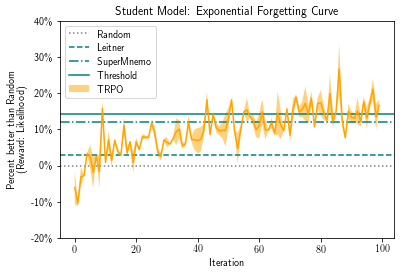

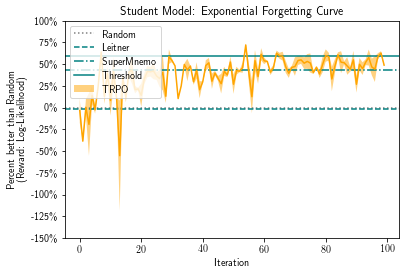

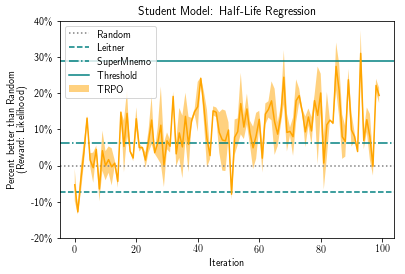

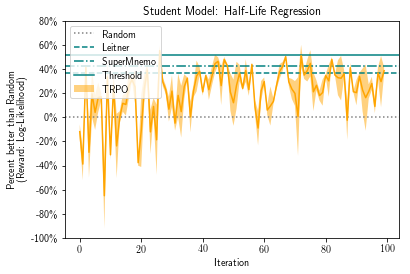

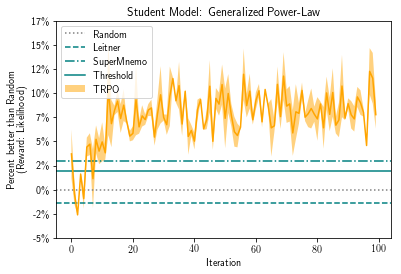

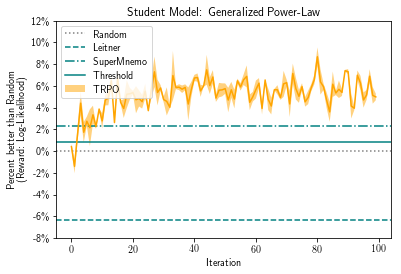

In [110]:
for h, (env_name, _) in enumerate(envs):
  for m, reward_func in enumerate(reward_funcs):
    k = h*len(reward_funcs)+m
    
    plt.xlabel('Iteration')
    plt.ylabel('Percent better than Random\n(Reward: %s)' % reward_func.replace('_', '-').replace('likelihood', 'Likelihood').replace('log', 'Log'))
    plt.title('Student Model: %s' % title_of_env_name[env_name])

    colors = ['gray', 'teal', 'teal', 'teal', 'orange']
    styles = ['dotted', 'dashed', 'dashdot', 'solid', 'solid']
    for i, (tutor_name, _) in enumerate(tutor_builders):
      if tutor_name == 'RL': tutor_name = 'TRPO'
      if tutor_name == 'TRPO':
        x = range(R.shape[2])
        y1 = r_mins(R[k, i, :, :])
        y2 = r_maxs(R[k, i, :, :])
        plt.fill_between(x, y1, y2, where=y2 >= y1, facecolor=colors[i], interpolate=True, alpha=0.5, label=tutor_name)
        plt.plot(r_means(R[k, i, :, :]), color=colors[i])
      else:
        plt.axhline(y=np.nanmean(R[k, i, :, :]), color=colors[i], linestyle=styles[i], label=tutor_name)
    
    plt.yticks(plt.yticks()[0], [str(int(x)) + r'\%' for x in plt.yticks()[0]])
        
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(data_dir, '%s-%s.pdf' % (env_name, reward_func)), bbox_inches='tight')
    plt.show()